<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data0 = pd.read_csv('/datasets/Churn.csv')
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Открываем файл с данными и изучаем общую информацию. В таблице нет пропусков кроме столбца *'Tenure'*. Большинство данных имеют тип  float, int, object, в столбце *'Exited'* данные имеют тип int.

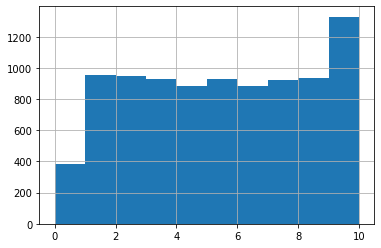

In [3]:
data0['Tenure'].hist()

In [4]:
data0['Tenure'] = data0['Tenure'].fillna(-1)

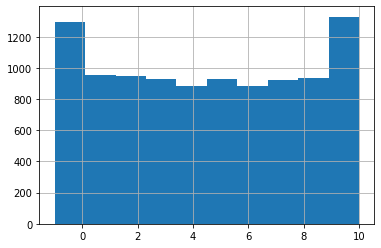

In [5]:
data0['Tenure'].hist()

In [6]:
del data0['RowNumber']
del data0['CustomerId']
del data0['Surname']

In [7]:
data0.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Наши данные содержат категориальные признаки. Исправим это с помощью  метода *pd.get_dummies()*.

In [8]:
data = pd.get_dummies(data0, drop_first=True)

In [9]:
data_train, data_test = train_test_split(data, test_size=0.15, random_state=12345)

In [10]:
df_train, df_valid = train_test_split(data_train, test_size=0.25, random_state=12345)

In [11]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

Для того, чтобы разбить данные на выборки воспользуемся методом *train_test_split()*. В тестовой выборке получилось 15% от всего набора данных, 64% - в обучающей и 21% - в валидационной.

In [12]:
numeric = ['CreditScore', 'Age', 'Tenure',
           'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
           'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]= scaler.transform(features_valid[numeric]) 
features_test[numeric]= scaler.transform(features_test[numeric]) 

Все признаки значимы. Признаки масштабируются — приводятся к одному масштабу. Один из методов масштабирования — стандартизации данных. В sklearn есть отдельная структура для стандартизации данных —  StandardScaler (от англ. «преобразователь масштаба методом стандартизации»). Он находится в модуле sklearn.preprocessing.

## Исследование задачи

In [13]:
data['Exited'].value_counts(normalize = True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Получили, что около 80% клиентов перестали пользоваться услугами банка. Поскольку соотношение классов далеко от 1:1, следовательно, они являются несбалансированными.

Исследуем качество разных моделей, меняя гиперпараметры.

In [14]:
for depth in range(1,10):
    modelDTC = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    modelDTC.fit(features_train,target_train) # обучили модель
    predictions_validDTC = modelDTC.predict(features_valid) 
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_validDTC)) 

max_depth = 1 : 0.792
max_depth = 2 : 0.8291764705882353
max_depth = 3 : 0.8390588235294117
max_depth = 4 : 0.843764705882353
max_depth = 5 : 0.8498823529411764
max_depth = 6 : 0.8527058823529412
max_depth = 7 : 0.8541176470588235
max_depth = 8 : 0.8512941176470589
max_depth = 9 : 0.8418823529411765


При использовании модели классификации **деревом решений** можно сделать вывод, что **качество модели самое высокое, когда глубина дерева равна 7**. Хуже всего, когда дерево является пнём.

In [15]:
for est in range(1, 11):
    modelRFC = RandomForestClassifier(random_state=12345, n_estimators = est) 
    modelRFC.fit(features_train,target_train) 
    predictions_validRFC = modelRFC.predict(features_valid) 
    print("n_estimators =", est, ": ", end='')
    print(accuracy_score(target_valid, predictions_validRFC)) 

n_estimators = 1 : 0.7755294117647059
n_estimators = 2 : 0.8272941176470588
n_estimators = 3 : 0.8287058823529412
n_estimators = 4 : 0.8404705882352941
n_estimators = 5 : 0.8414117647058823
n_estimators = 6 : 0.8484705882352941
n_estimators = 7 : 0.8494117647058823
n_estimators = 8 : 0.8555294117647059
n_estimators = 9 : 0.8489411764705882
n_estimators = 10 : 0.8494117647058823


Попробуем алгоритм классификации — случайный лес. Алгоритм обучает большое количество независимых друг от друга деревьев, а потом принимает решение на основе голосования. Случайный лес помогает улучшить результат предсказания и избежать переобучения.

Из данных, которые мы получили, заключаем, что при увеличении количества деревьев в лесу (что является гиперпараметром этой модели)  от 1 до 7 качество модели улудшается. Самое низкое качество, когда дерево в лесу одно, самое высокое при 8 деревьях в лесу.

Решила вывести какие факторы важны. Получилось, что страна проживания клиента банка является самым важным фактором, поскольку у неё самый большой вес.

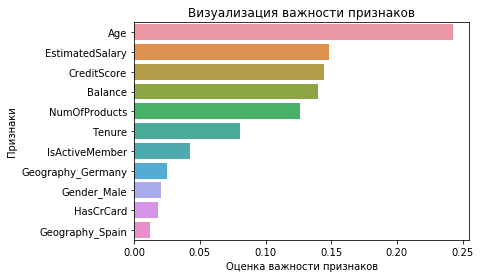

In [18]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_valid.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(modelRFC)


In [18]:
modelLR =LogisticRegression(random_state=12345) 
modelLR.fit(features_train,target_train) 
predictions_validLR = modelLR.predict(features_valid) 
print("Accuracy модели логистической регрессии на валидационной выборке:", accuracy_score(target_valid, predictions_validLR))

Accuracy модели логистической регрессии на валидационной выборке: 0.8103529411764706


Качество модели логистической регресии самое низкое, если сравнивать со случайным лесом и решающим деревом.

## Борьба с дисбалансом

Алгоритмы машинного обучения считают все объекты обучающей выборки равнозначными по умолчанию. Если важно указать, что какие-то объекты важнее, их классу присваивается вес. В алгоритме логистической регрессии в библиотеке sklearn есть аргумент class_weight. По умолчанию он равен None, т. е. классы равнозначны. Если указать class_weight='balanced' (англ. «сбалансированный»), алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1». 

Оценим качество работы моделей с помощью метрики F1, что есть среднее гармоническое полноты и точности.

In [19]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('LogisticRegression')
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Площадь под ROC-кривой:', auc_roc)

LogisticRegression
F1: 0.48852459016393446
Площадь под ROC-кривой: 0.764972052169284


Аргумент class_weight также есть у решающего дерева и случайного леса.

In [20]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced', n_estimators = 8)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('RandomForestClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Площадь под ROC-кривой:', auc_roc)

RandomForestClassifier
F1: 0.5295857988165681
Площадь под ROC-кривой: 0.8113339947249982


In [21]:
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth = 7)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Площадь под ROC-кривой:', auc_roc)

DecisionTreeClassifier
F1: 0.6068965517241379
Площадь под ROC-кривой: 0.8366570953076142


По-прежнему выигрывает модель дерева решений (даже при сравнении с ROC-кривой).

Теперь попробуем сделать объекты редкого класса не такими редкими в данных.

Когда обучают модели, такая техника называется upsampling.

In [22]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [23]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [24]:
model = LogisticRegression(random_state = 12345, solver ='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('LogisticRegression')
print("F1:", f1_score(target_valid, predicted_valid))

LogisticRegression
F1: 0.4250394529195161


In [25]:
model = RandomForestClassifier(random_state=12345, n_estimators = 8)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('RandomForestClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

RandomForestClassifier
F1: 0.5805626598465473


In [26]:
model = DecisionTreeClassifier(random_state=12345, max_depth = 7)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

DecisionTreeClassifier
F1: 0.4860606060606061


На удивление при уменьшении выборки лучше всего себя показала модель случайного леса.

Также стоит попробовать сделать объекты частого класса не такими частыми.

Вместо повторения важных вопросов, уберём часть неважных. Это можно сделать техникой downsampling.

In [27]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [28]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [29]:
model = LogisticRegression(random_state = 12345, solver ='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('LogisticRegression')
print("F1:", f1_score(target_valid, predicted_valid))

LogisticRegression
F1: 0.4268484530676455


In [30]:
model = RandomForestClassifier(random_state=12345, n_estimators = 8)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('RandomForestClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

RandomForestClassifier
F1: 0.4961038961038961


In [31]:
model = DecisionTreeClassifier(random_state=12345, max_depth = 7)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('DecisionTreeClassifier')
print("F1:", f1_score(target_valid, predicted_valid))

DecisionTreeClassifier
F1: 0.48792884371029227


Здесь  лучшее F1-качество показывает модель дерева решений.

## Тестирование модели

In [32]:
predictions_testLR = modelLR.predict(features_test)
print("F1 модели LogisticRegression")
print("Тестовая выборка:", f1_score(target_test, predictions_testLR))

F1 модели LogisticRegression
Тестовая выборка: 0.2946859903381642


In [33]:
predictions_testRFC = modelRFC.predict(features_test)
print("F1 модели RandomForestClassifier")
print("Тестовая выборка:", f1_score(target_test, predictions_testRFC))

F1 модели RandomForestClassifier
Тестовая выборка: 0.5265306122448979


In [34]:
predictions_testDTC = modelDTC.predict(features_test)
print("F1 модели DecisionTreeClassifier")
print("Тестовая выборка:", f1_score(target_test, predictions_testDTC))

F1 модели DecisionTreeClassifier
Тестовая выборка: 0.5546558704453441
